## Historic CMIP

For historical comparison, it is crucial to compare the model output of discharge data using CMIP6 forcings to observation data. This comparison helps to determine the uncertainty of the model and shows how well the model predicts discharge data. The uncertainy of the model will be determined in the analysis. 

In [1]:
# general python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import geopandas as gpd
import pandas as pd
import seaborn as sns

#niceties
from rich import print


# general eWaterCycle
import ewatercycle
import ewatercycle.models
import ewatercycle.forcing


## Choose region and time period

In [2]:
# name of the catchment
basin_name = "FR000119"

# defining dates for calibration
historical_start_date = "1990-01-01T00:00:00Z"
historical_end_date = "2014-12-31T00:00:00Z"

#Define Catchment Area
shapefile_path = Path.home() / "BEP-Elke" / "book" / "thesis_projects" / "BSc" / "2025_Q4_ElkeSchokking_CEG" / "work in progress" / "ShapefilesFR000119" / "FR000119.shp"


### Set up paths

In [3]:
# Location forcing files in home directory
forcing_path_CMIP = Path.home() / "forcing" / "FR000119"/"CMIP"
forcing_path_CMIP.mkdir(exist_ok=True)

### Catchment

<Axes: >

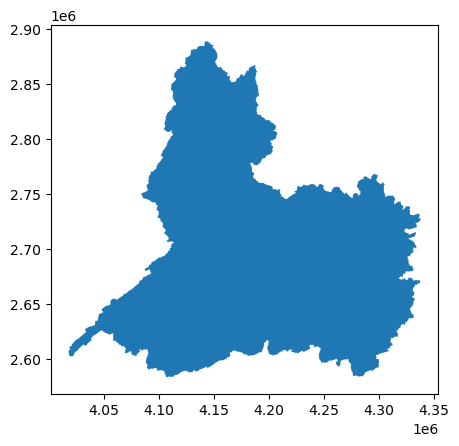

In [4]:
catchment = gpd.read_file(shapefile_path)
catchment = catchment.to_crs(epsg=3035)
catchment["area_km2"] = catchment.geometry.area / 1e6  
basin_area = catchment["area_km2"].sum()
catchment.plot()

## CMIP dataset information

In [5]:
cmip_historical = {
    "dataset": "EC-Earth3",
    "project": "CMIP6",
    "grid": "gr",
    "exp": "historical",
    "ensemble": "r6i1p1f1",
}

## Generate CMIP forcing

In [6]:
# # option one: generate forcing:
# CMIP_forcing = ewatercycle.forcing.sources["LumpedMakkinkForcing"].generate(
#    dataset=cmip_dataset,
#    start_time=historical_start_date,
#    end_time=historical_end_date,
#    shape=shapefile_path,
#    directory=forcing_path_CMIP,
# )

In [7]:
#CMIP_forcing.save()

In [8]:
# Option two: load generated data
# Load historical data
historic_location = Path('/home/elke/forcing/FR000119/CMIP/work/diagnostic/script/')
historical = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(directory=historic_location)

In [9]:
print(historical)

LumpedMakkinkForcing(
    start_time='1990-01-01T00:00:00Z',
    end_time='2014-12-31T00:00:00Z',
    directory=PosixPath('/home/elke/forcing/FR000119/CMIP/work/diagnostic/script'),
    shape=PosixPath('/home/elke/forcing/FR000119/CMIP/work/diagnostic/script/FR000119.shp'),
    filenames={
        'pr': 'CMIP6_EC-Earth3_day_historical_r6i1p1f1_pr_gr_1990-2014.nc',
        'tas': 'CMIP6_EC-Earth3_day_historical_r6i1p1f1_tas_gr_1990-2014.nc',
        'rsds': 'CMIP6_EC-Earth3_day_historical_r6i1p1f1_rsds_gr_1990-2014.nc',
        'evspsblpot': 'Derived_Makkink_evspsblpot.nc'
    }
)

## Setting up the model

### Parameters

In [10]:
#Calibrated parameters, logNSE & EMD
par_0 = [4.533, 0.4272, 442.0109, 1.0321, 0.0714, 8.5025, 0.0139, 0.0099, 1.085]
param_names = ['Imax', 'Ce', 'Sumax', 'Beta', 'Pmax', 'Tlag', 'Kf', 'Ks', 'FM']

print(list(zip(param_names, np.round(par_0, decimals=3))))

[
    ('Imax', 4.533),
    ('Ce', 0.427),
    ('Sumax', 442.011),
    ('Beta', 1.032),
    ('Pmax', 0.071),
    ('Tlag', 8.502),
    ('Kf', 0.014),
    ('Ks', 0.01),
    ('FM', 1.085)
]

In [11]:
# Starting values for HBV storages (in mm)
# [Si, Su, Sf, Ss, Sp]

s_0 = np.array([0, 100, 0, 5, 0])

### HBV model

In [12]:
model = ewatercycle.models.HBV(forcing=historical)

In [13]:
config_file, _ = model.setup(parameters=par_0, initial_storage=s_0)

In [14]:
model.initialize(config_file)

### Running the model

In [15]:
Q_m = []
time = []
while model.time < model.end_time:
    model.update()
    Q_m.append(model.get_value("Q")[0])
    time.append(pd.Timestamp(model.time_as_datetime))

In [16]:
model.finalize()

### Process results

In [17]:
model_output = pd.Series(data=Q_m, name="Modelled discharge", index=time)

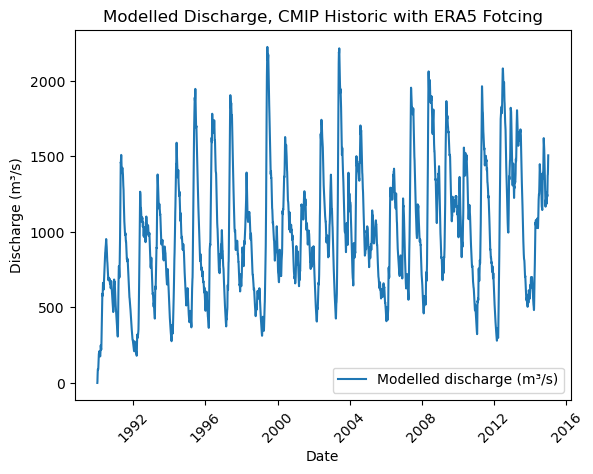

In [27]:
df = pd.DataFrame(model_output)
model_data = df['Modelled discharge'] * basin_area * 1000 / (24 * 60 * 60)
plt.plot(model_data, label='Modelled discharge (m³/s)')

plt.xlabel('Date')
plt.ylabel('Discharge (m³/s)')
plt.title('Modelled Discharge, CMIP Historic with ERA5 Fotcing')
plt.xticks(rotation=45)
plt.legend()

plt.show()

In [28]:
print(model_data.head())
print(model_data.tail())

date
1990-01-02 12:00:00     0.687406
1990-01-03 12:00:00     2.819908
1990-01-04 12:00:00     7.148307
1990-01-05 12:00:00    15.041822
1990-01-06 12:00:00    26.821341
Name: Modelled discharge, dtype: float64

date
2014-12-27 12:00:00    1438.602425
2014-12-28 12:00:00    1462.788326
2014-12-29 12:00:00    1485.095391
2014-12-30 12:00:00    1501.100521
2014-12-31 12:00:00    1507.211909
Name: Modelled discharge, dtype: float64

The model outputs are converted to a .CSV file to be used in the analysis. The values of the first year are removed, because the model first needs to 'fill', meaning these first values could be inaccurate.

In [20]:
# Convert Series to DataFrame and rename the column
historic_df = model_data.to_frame(name="Historic")

# Set index name to "date" for consistency
historic_df.index.name = "date"

# Remove all data from the year 1990
historic_df = historic_df[historic_df.index.year > 1990]

# Save to CSV
historic_df.to_csv("Historic_discharge.csv")

In [21]:
historic_df.head()

,Historic
date,
1991-01-01 12:00:00,569.907425
1991-01-02 12:00:00,562.256235
1991-01-03 12:00:00,554.711284
1991-01-04 12:00:00,547.271107
1991-01-05 12:00:00,539.934230


### Plot against observed discharge

In [22]:
# Slice model data to 2013–2019
model_data_filtered = model_data["2013-01-01":"2019-12-31"]

In [23]:
# Manually parse the file
dates = []
discharges = []

with open("A3550050.csv", "r", encoding="utf-8") as f:
    next(f)
    for line in f:
        parts = line.replace('""', '"').strip().split(',"')
        if len(parts) >= 2:
            date_str = parts[0].strip('"')
            discharge_str = parts[1].strip('"')
            try:
                dates.append(pd.to_datetime(date_str))
                discharges.append(float(discharge_str))
            except ValueError:
                continue

In [24]:
obs_series = pd.Series(discharges, index=dates, name="Observed Discharge (m³/s)")
obs_filtered = obs_series["2013-01-01":"2019-12-31"]

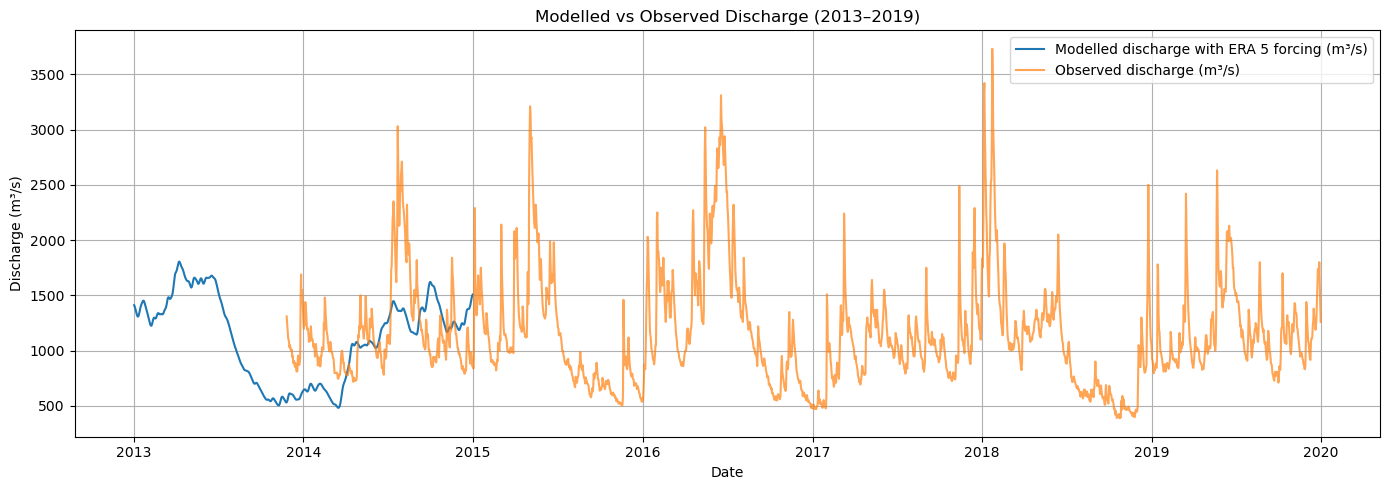

In [25]:
plt.figure(figsize=(14, 5))
plt.plot(model_data_filtered, label='Modelled discharge with ERA 5 forcing (m³/s)')
plt.plot(obs_filtered, label='Observed discharge (m³/s)', alpha=0.7)

plt.xlabel("Date")
plt.ylabel("Discharge (m³/s)")
plt.title("Modelled vs Observed Discharge (2013–2019)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

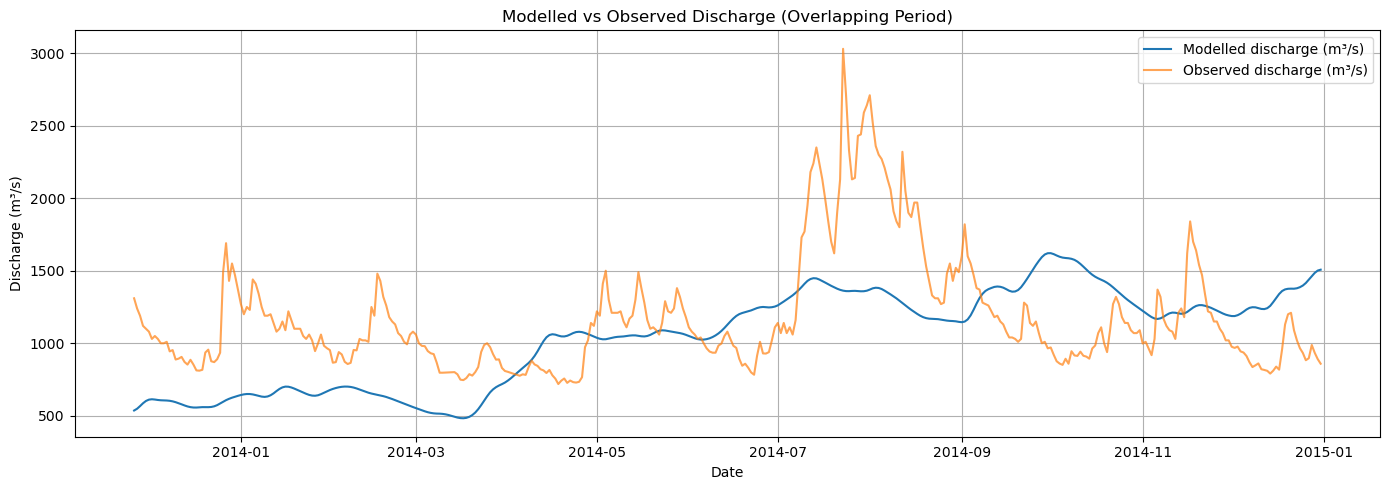

In [26]:
# Convert both indices to timezone-naive before processing
model_data_filtered.index = model_data_filtered.index.tz_convert(None) if model_data_filtered.index.tz else model_data_filtered.index
obs_filtered.index = obs_filtered.index.tz_convert(None) if obs_filtered.index.tz else obs_filtered.index

# Normalize timestamps to midnight to align daily data
model_data_filtered.index = model_data_filtered.index.normalize()
obs_filtered.index = obs_filtered.index.normalize()

# Sort indices
model_data_filtered = model_data_filtered.sort_index()
obs_filtered = obs_filtered.sort_index()

# Determine overlapping date range
start_date = max(model_data_filtered.index.min(), obs_filtered.index.min())
end_date = min(model_data_filtered.index.max(), obs_filtered.index.max())

# Slice to overlapping period
model_overlap = model_data_filtered[start_date:end_date]
obs_overlap = obs_filtered[start_date:end_date]

# Align on common dates and drop any missing values
combined = pd.concat([model_overlap, obs_overlap], axis=1).dropna()
model_aligned = combined.iloc[:, 0]
obs_aligned = combined.iloc[:, 1]

# Plot
plt.figure(figsize=(14, 5))
plt.plot(model_aligned, label='Modelled discharge (m³/s)')
plt.plot(obs_aligned, label='Observed discharge (m³/s)', alpha=0.7)
plt.xlabel("Date")
plt.ylabel("Discharge (m³/s)")
plt.title("Modelled vs Observed Discharge (Overlapping Period)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()